In [1]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

import geopandas as gpd
import pandas as pd
import glob
import zipfile
# import rasterio
import os
import xarray as xr
from pathlib import Path


Populating the interactive namespace from numpy and matplotlib


In [2]:
print(os.getcwd())
from pathlib import Path
folder = Path(r'../Data_v1_1') # assumes working directory is onhm-fetcher-parser
print(folder)
# shapefiles = folder.glob("*_0[1-2].shp")
# glob below is not necessary in this case as there is only one shapefile.  Will keep
# code this way as in the case of HRUs split into multiple shapefiles this is how to concatenate
# into one geodataframe

shapefiles = folder.glob("*2e*.shp")
gdf = pd.concat([
    gpd.read_file(shp)
    for shp in shapefiles
]).pipe(gpd.GeoDataFrame)
gdf.reset_index(drop=True, inplace=True)

C:\Users\rmcd\git\onhm-fetcher-parser\notebooks
..\Data_v1_1


In [3]:
def get_dm_files(idir, year):
    fprcp = None
    ftmax = None
    ftmin = None

    vprcp = 'prcp'
    vtmax = 'tmax'
    vtmin = 'tmin'

    fprcp = idir / vprcp / f'daymet_v3_{vprcp}_{year}_na.nc4'
    ftmax = idir / vtmax / f'daymet_v3_{vtmax}_{year}_na.nc4'
    ftmin = idir / vtmin / f'daymet_v3_{vtmin}_{year}_na.nc4'

    return xr.open_mfdataset([fprcp, ftmax, ftmin], combine='by_coords')

In [10]:
def get_dm_files2(idir, year):
    fprcp = None
    ftmax = None
    ftmin = None

    vprcp = 'prcp'
    vtmax = 'tmax'
    vtmin = 'tmin'

    fprcp = idir / f'daymet_v3_{vprcp}_{year}_na.nc4'
    ftmax = idir / f'daymet_v3_{vtmax}_{year}_na.nc4'
    ftmin = idir / f'daymet_v3_{vtmin}_{year}_na.nc4'

    return xr.open_dataset(fprcp), xr.open_dataset(ftmax), xr.open_dataset(ftmin)

In [11]:
def np_get_wval(ndata, wghts, hru_id):
    """
    Returns weighted average of ndata with weights = grp
    1) mdata = the subset of values associated with the gridmet id's that are mapped to hru_id.
    2) Some of these values may have nans if the gridmet id is outside of conus so only return values
    that are inside of conus
    3) this means that hru's that are entirely outside of conus will return nans which will ultimately,
    outside of this function get assigned zero's.
    4) the value is assigned the weighted average
    :param ndata: float array of data values
    :param wghts: float array of weights
    :param hru_id hru id number
    :return: numpy weighted averaged - masked to deal with nans associated with
            ndata that is outside of the conus.
    """
    mdata = np.ma.masked_array(ndata[wghts['grid_ids'].values.astype(int)],
                               np.isnan(ndata[wghts['grid_ids'].values.astype(int)]))

    # mdata = np.ma.masked_where(ndata[wghts['grid_ids'].values.astype(int)] <= 0.0,
    #                            (ndata[wghts['grid_ids'].values.astype(int)]))
    tmp = np.ma.average(mdata, weights=wghts['w'])
    if tmp is masked:
        # print('returning masked value', hru_id, mdata, wghts['w'])
        return np.nan

    else:
        return tmp

In [12]:
wd = Path('../Data_v1_1')

var = 'prcp'
year = '1980'
file = f'daymet_v3_{var}_{year}_na.nc4'
print(file)
fprcp = wd / var / f'daymet_v3_{var}_{year}_na.nc4'
fprcp.exists()

daymet_v3_prcp_1980_na.nc4


False

In [13]:
xmin = -2754.25 
xmax = 3252.75
ymin = -2011.0
ymax = 1687.0

In [14]:
dp,dtmax,dtmin = get_dm_files2(wd, year)
tprcp = dp.sel(
    y=slice(ymax*1000.0, ymin*1000.0), 
    x=slice(xmin*1000.0,xmax*1000.0))
ttmax = dtmax.sel(
    y=slice(ymax*1000.0, ymin*1000.0), 
    x=slice(xmin*1000.0,xmax*1000.0))
ttmin = dtmin.sel(
    y=slice(ymax*1000.0, ymin*1000.0), 
    x=slice(xmin*1000.0,xmax*1000.0))

In [19]:
ts = tprcp.sizes
ts['time']

365

In [23]:
count = 0
for i in range(10):
    count += 1
    print(i, count)

0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10


In [31]:
tprcp.prcp.sel(time='1980-01-01').values

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)

In [32]:
import datetime as dt
date = dt.datetime(year=int(year), month=1, day=1, hour=12)
tprcp.prcp.sel(time=date).values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [33]:
lon = tprcp.lon.values
lat = tprcp.lat.values

In [34]:
np.shape(lon)

(3699, 6008)

In [35]:
import netCDF4
netCDF4.default_fillvals['f8']

9.969209968386869e+36

In [43]:
np.arange(0,10,dtype=np.float)

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [38]:
from numpy.ma import masked
# add tmax column to dataframe
gdf['tmax']=0.0
# gdf.tmax[noint] = 10.0
# print(gdf.tmax[noint])

wght_UofI = pd.read_csv('../Data_v1_1/tmp_daymet_weights_hru_v1_1e.csv')
print(wght_UofI.head())
wghts_id = wght_UofI.columns[1]
print('wghts_id', wghts_id)
#iterate through hru's, grab all weights associated with hru_id, get total weighted value from netcdf file, assign to tmax
# ndata = datahandle.values[dayshape-1,:,:].flatten(order='C')
# ndata = ds.tmax.values[dayshape-1,:,:].flatten()
# lon = tds.lon.values
# lat = tds.lat.values
ndata = np.zeros((3, (np.shape(lon)[1] -2)*(np.shape(lon)[0]-2)))
date = dt.datetime(year=int(year), month=1, day=1, hour=12)
dprcp = tprcp.prcp.sel(time=date)
dtmax = ttmax.tmax.sel(time=date)
dtmin = ttmin.tmin.sel(time=date)
tlc = 0


   grid_ids  nhru_v11         w
0  17997007     76127  0.000885
1  17997011     76127  0.002030
2  17997010     76127  0.004571
3  17997009     76127  0.004744
4  17997008     76127  0.001928
wghts_id nhru_v11


In [39]:
ndata[0,:] = tprcp.prcp.sel(time=date).values[1:np.shape(lon)[0] - 1,1:np.shape(lon)[1] - 1].flatten()
ndata[1,:] = ttmax.tmax.sel(time=date).values[1:np.shape(lon)[0] - 1,1:np.shape(lon)[1] - 1].flatten()
ndata[2,:] = ttmin.tmin.sel(time=date).values[1:np.shape(lon)[0] - 1,1:np.shape(lon)[1] - 1].flatten()

In [40]:
unique_hru_ids = wght_UofI.groupby(wghts_id)
print(len(gdf), len(unique_hru_ids))
td = np.zeros((3,len(gdf.index)))
for index, row in gdf.iterrows():
#     if not(row['nhm_id'] in noint):
    try: 
        weight_id_rows = unique_hru_ids.get_group(row[wghts_id])
        td[0,index] = np.nan_to_num(np_get_wval(ndata[1,:], weight_id_rows, index+1))
    except KeyError:
        td[0,index] = 0.0
            
            
#         gdf['tmax'][index] = np_get_wval2(weight_id_rows, ndata)
#     else:
#         td[index] = 10.0

gdf['tmax'] = td[0,:].tolist()
# gdf['tmax'].fillna(0.0)

print('min/max', gdf['tmax'].min(), gdf['tmax'].max())


139809 114958
min/max -13.667109587577722 24.5


In [49]:
avg_c = unique_hru_ids.grid_ids.count()

In [56]:
avg_c.max()

67514

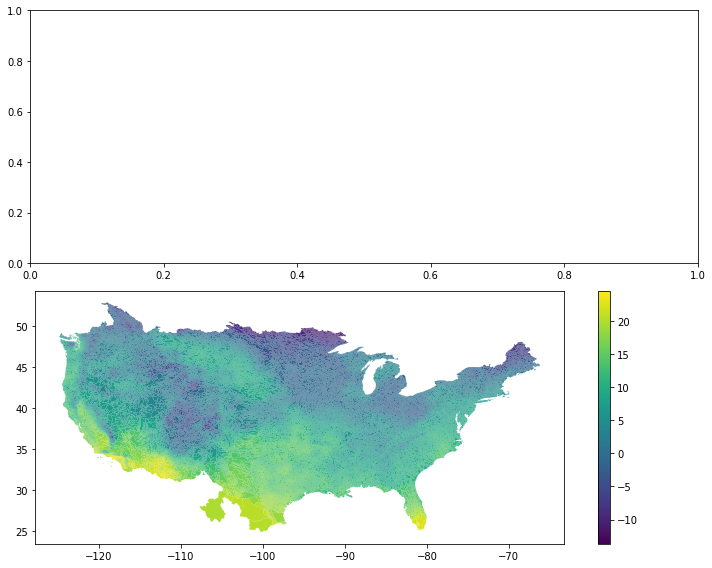

In [64]:
f, ax = plt.subplots(2, 1)

lvs = np.arange(gdf['tmax'].min(), gdf['tmax'].max(), 0.5)

# ptmax = ds.tmax
# ptmax_1 = ptmax.isel(time=dayshape-1)
# p=ptmax_1.plot(ax=ax[0], levels=lvs, cmap='viridis')
# ax[0].set_aspect('equal', 'box')

g = gdf.plot(ax=ax[1], column = 'tmax',linewidth=0., edgecolor='white', legend=True)
# temp = ds.daily_maximum_temperature[0,:,:]-273.5
ax[1].set_aspect('equal', 'box')


plt.tight_layout()
plt.show()

In [42]:
tlc = 0
for i in range(1, np.shape(lon)[0] - 1):
    if i % 100 == 0: print(i, flush=True)
    for j in range(1, np.shape(lon)[1] - 1):
        ndata[0, tlc] = dprcp.values[i,j]
        ndata[1,tlc] = dtmax.values[i,j]
        ndata[2,tlc] = dtmin.values[i,j]
        tlc+=1

# print(ndata[1000:])

# unique_hru_ids = wght_UofI.groupby(wghts_id)
# print(len(gdf), len(unique_hru_ids))

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300


KeyboardInterrupt: 

In [21]:
i

1

In [22]:
j

5428

In [23]:
dprcp.values[i,j]

0.0

In [24]:
ndata

array([nan, nan, nan, ...,  0.,  0.,  0.])